In [1]:
#Importe des fonctions utiles
import requests
import pandas as pd
import io
import collections
from itertools import combinations
import networkx as nx
pd.options.display.max_colwidth = 100
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#Importe les fonctions pour travailler avec l'API de HAL, pour les détails, voir
# https://colab.research.google.com/github/Yquetzal/Teaching_notebooks/blob/main/Networks/cours_HAL_network.ipynb#scrollTo=d1ee2598

!wget https://raw.githubusercontent.com/Yquetzal/Teaching_notebooks/main/Networks/HALfunctions.py


--2023-11-27 11:35:24--  https://raw.githubusercontent.com/Yquetzal/Teaching_notebooks/main/Networks/HALfunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9183 (9.0K) [text/plain]
Saving to: ‘HALfunctions.py.2’

HALfunctions.py.2   100%[===================>]   8.97K  --.-KB/s    in 0s      

2023-11-27 11:35:25 (56.9 MB/s) - ‘HALfunctions.py.2’ saved [9183/9183]



In [3]:
from HALfunctions import get_all_elements, co_occurence_network,co_occurence_network_laboratory,column_most_common,bi_partite_network,bi_partite_network_generic

# Faire la requête

In [83]:
# Here, detail the request. This exmaple: articles whose abstract contains "easy", 
# published between 2020 et 2022, at l'université de Lyon.

domain="UNIV-LYON/"
words="(network OR graph)"
dates="[2015 TO 2022]"
columns="title_s,authFullName_s,structAcronym_s,structCountry_s,structAddress_s,structType_s,structName_s,level1_domain_s,keyword_s,publicationDateY_i"

request = "http://api.archives-ouvertes.fr/search/"+domain+"?q="+words+"&fq=publicationDate_s:"+dates+"&fl="+columns
simple_example = get_all_elements(request)
simple_example.head(3)

Nombre d'éléments au total :  3334
Éléments récupérés :  1000
Éléments récupérés :  2000
Éléments récupérés :  3000
Éléments récupérés :  3334


,title_s,authFullName_s,structAcronym_s,structCountry_s,structAddress_s,structType_s,structName_s,level1_domain_s,keyword_s,publicationDateY_i
0,Advanced Virgo: a second-generation interferometric gravitational wave detector,"F. Acernese,M. Agathos,K. Agatsuma,D. Aisa,N. Allemandou,A. Allocca,J. Amarni,P. Astone,G. Bales...","LAPP,IN2P3,USMB [Université de Savoie] [Université de Chambéry],CNRS,APC (UMR_7164),CEA,IN2P3,PS...","fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,it,it,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,...","9 Chemin de Bellevue - BP 110 - 74941 Annecy-le-Vieux CEDEX - France,CENTRE NATIONAL DE LA RECHE...","laboratory,institution,institution,regroupinstitution,laboratory,institution,institution,institu...","Laboratoire d'Annecy de Physique des Particules,Institut National de Physique Nucléaire et de Ph...","phys.grqc,phys.phys",NaN,2015
1,De l'habileté dans les interactions numériques aux compétences professionnelles de l'animateur d...,"Valérie Larroche,Hélène Piment","ELICO,UL2,ENSSIB,IEP Lyon,UJML,UCBL","fr,fr,fr,fr,fr,fr,fr,fr,fr,fr","Université Lumière Lyon 2 - Département ICOM5 avenue Pierre-Mendes-France 69676 Bron,86\, rue Pa...","laboratory,institution,institution,regroupinstitution,institution,regroupinstitution,institution...","Equipe de recherche de Lyon en sciences de l'information et de la communication,Université Lumiè...",shs.info,"Media visibility,Enterprise social network,Professional digital identity,Professional recognitio...",2015
2,Characterization of the LIGO detectors during their sixth science run,"J. Aasi,M.-A. Bizouard,V. Brisson,F. Cavalier,M. Davier,S. Franco,P. Hello,N. Leroy,F. Robinet,T...","CALTECH,LAL,UP11,IN2P3,CNRS,LAPP,IN2P3,USMB [Université de Savoie] [Université de Chambéry],CNRS...","us,us,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr","91125;Pasadena,1200 East California Blvd\, Pasadena\, California 91125,Centre Scientifique d'Ors...","laboratory,institution,laboratory,institution,institution,regroupinstitution,laboratory,institut...","LIGO,California Institute of Technology,Laboratoire de l'Accélérateur Linéaire,Université Paris-...","phys.grqc,phys.astr",NaN,2015


In [84]:
from collections import Counter

def list_per_year(df,column_name):

    df = df.copy()
    df[column_name]=[str(k).replace("\\,","_").split(",") for k in df[column_name]]
    df_exploded = df.explode(column_name)
    df_exploded = df_exploded[df_exploded[column_name]!="nan"]

    df_by_year = df_exploded.groupby("publicationDateY_i").agg({column_name: lambda x: list(x)})
    return df_by_year

In [85]:
def count_per_year(df,column_name):
    df = df.copy()
    df_by_year = list_per_year(df,column_name)
    #df_by_year["count"]=[Counter(k) for k in df_by_year[column_name]]
    #explode in two columns, name and count
    df_by_year = df_by_year.explode(column_name)
    #remove where value of column column_name is "nan"

    df_by_year = df_by_year.groupby(["publicationDateY_i",column_name]).agg(nb_occ= (column_name,"count"))
    #df_by_year["name"] = [k[0] for k in df_by_year["count"]]
    #df_by_year["count"] = [k[1] for k in df_by_year["count"]]
    
    return df_by_year

In [87]:
df = count_per_year(simple_example,"keyword_s").reset_index()

In [89]:
df.sort_values("nb_occ",ascending=False).head(5)

,publicationDateY_i,keyword_s,nb_occ
12110,2021,Deep learning,17
10069,2020,Deep learning,12
12392,2021,France,11
3668,2017,Analyse de réseaux,9
10882,2020,Network,9


In [94]:
#filter table so as to keep only the most common keywords, first grouping per year summing and filtering
df_count = df.groupby(["keyword_s"]).agg(nb_occ= ("nb_occ","sum")).reset_index()

df_count = df_count[df_count["nb_occ"]>30]
#then, filter the original table
df = df[df["keyword_s"].isin(df_count["keyword_s"])]


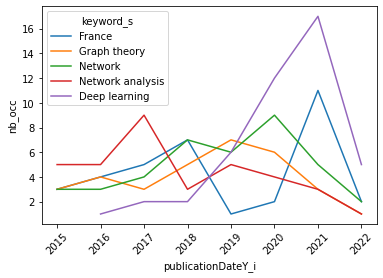

In [95]:
#plot evolution keywords usage over time
sns.lineplot(data=df,x="publicationDateY_i",y="nb_occ",hue="keyword_s")
#make dates readable
plt.xticks(rotation=45)
#display only ticks per year, i.e., integer values
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

<Axes: xlabel='publicationDateY_i', ylabel='nb_occ'>

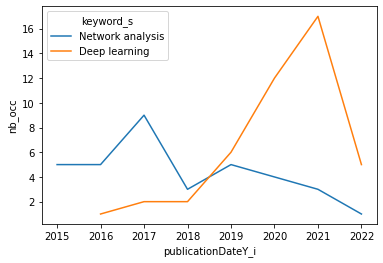

In [96]:
# or keep only specific keywords "Network analysis" and "Deep learning"
df = df[df["keyword_s"].isin(["Network analysis","Deep learning"])]
sns.lineplot(data=df,x="publicationDateY_i",y="nb_occ",hue="keyword_s")
